In [2]:
import numpy as np
from IPython.display import Audio
import librosa, librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from audiomentations import Compose, AddGaussianNoise, Gain, PitchShift, Shift
import torch
from torchvision import datasets, models, transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
# import torchaudio
# from torch.autograd import Variable
# from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

In [39]:
def get_mel_spectrogram(samples: np.array, sr: int = 44100, 
                        ) -> np.array:
    """
    :param samples (np.array): samples array of the audio
    :param sr (int): sample rate used for the samples
    :return mel_spectrogram (np.array): np.array containing 
                                      melspectrogram features in decibels
    """
    hop_length = len(samples)//256
    
    # get mel spectrogram image data
    mel_features = librosa.feature.melspectrogram(
        y=samples, sr=sr, hop_length=hop_length, n_mels=256)
    
    # clip the array to fit our target image shape
    mel_features = mel_features[:, :256]
    
    # convert to decibels as and normalize the image for efficiency
    mel_in_db = librosa.power_to_db(mel_features, ref=np.max)
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(mel_in_db)

In [4]:
def apply_augmentation(samples: np.array):

    gaussian_noise = AddGaussianNoise(
        min_amplitude=0.001,
        max_amplitude= 0.015,
        p=0.5
    )
    time_shift = Shift(
        min_fraction=-0.2,
        max_fraction=0.2,
        rollover=False,
        fade=True,
        p=0.5
    )
    pitch_shift = PitchShift(
        min_semitones=-0.5,
        max_semitones=0.5,
        p=0.25
    )
    gain = Gain(p=0.5)
    augmenter = Compose(
        [time_shift, gain, pitch_shift, gaussian_noise])
    return augmenter(samples=samples,
                     sample_rate=44100)

In [98]:
dataset_path = 'AVP-LVT_Dataset\AVP_Dataset\Personal'
dataset = pd.DataFrame(columns = ['Specs','Label', 'Audio'])

for subdir,_,files in os.walk(dataset_path):
    for filename in (files): 
        
        if filename.endswith('.csv'):
            onset_csv = pd.read_csv(os.path.join(subdir,filename), names=['Onsets','Inst','Phenome','Sil'])
            labels = onset_csv['Inst']
            onsets = np.floor(np.array(onset_csv['Onsets']) * 44100)
            onsets = onsets.astype(int)
        if filename.endswith('.wav'):
            x, sr = librosa.load(os.path.join(subdir,filename), sr = None)
            for i in range(1,len(onsets)):
                if i == 1:
                    x_audio = x[(onsets[i-1]):onsets[i]]
                else:
                    x_audio = x[(onsets[i-1]-1000):onsets[i]]
                #  x_temp = apply_augmentation(x_audio)
                x_audio = librosa.util.fix_length(x_audio, 11025)
                mel1 = get_mel_spectrogram(x_audio)
                dataset =  dataset.append({'Specs':mel1, 'Label':labels[i-1], 'Audio':x_audio}, ignore_index=True)
                x_temp = apply_augmentation(x_audio)
                x_audio = librosa.util.fix_length(x_temp, 11025)
                mel1 = get_mel_spectrogram(x_audio)
                dataset =  dataset.append({'Specs':mel1, 'Label':labels[i-1], 'Audio':x_audio}, ignore_index=True)
    


In [95]:
dataset.Label = pd.factorize(dataset.Label)[0]

In [4]:
def create_spectrogram_images(dataset):
    #make directory
    i = 0
    for _, row in dataset.iterrows():
        
        specs = row[0]
        label = row[1]

        
        directory = f'./spectrograms/{label}/'
        if(os.path.isdir(directory)):
            pass
        else:
            os.makedirs(directory, mode=0o777, exist_ok=True)
        
        plt.imsave(f'./spectrograms/{label}/spec_img{i}.png',specs, cmap='viridis')
        i += 1

In [100]:
create_spectrogram_images(dataset)

In [110]:
data = datasets.ImageFolder(root='./spectrograms', transform=transforms.ToTensor())
class_map=data.class_to_idx

print("\nClass category and index of the images: {}\n".format(class_map))
length = len(data)


train_data, val_data, test_data = torch.utils.data.random_split(data, [6693 , 2231, 2231])


Class category and index of the images: {'hhc': 0, 'hho': 1, 'kd': 2, 'sd': 3}



In [111]:
from collections import Counter

# labels in training set
train_classes = [label for _, label in train_data]
Counter(train_classes)

Counter({2: 2016, 1: 1362, 0: 1534, 3: 1781})

In [112]:
train_loader = DataLoader(train_data, batch_size=8,num_workers=2, shuffle = True)
val_loader = DataLoader(val_data, batch_size=8, num_workers=2, shuffle = True)
test_loader = DataLoader(test_data, batch_size=1, num_workers=2, shuffle = True)

In [113]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [114]:
class Network(torch.nn.Module):
   def __init__(self):
      super().__init__()

      self.layers = nn.Sequential(
         nn.Conv2d(3, 32, kernel_size=5),
         nn.MaxPool2d(2),
         nn.ReLU(),
         nn.Conv2d(32, 64, kernel_size=5),
         nn.Dropout2d(),
         nn.MaxPool2d(2),
         nn.ReLU(),
         nn.Flatten(),
         nn.Linear(64 * 61 * 61, 200),
         nn.ReLU(),
         nn.Dropout2d(),
         nn.Linear(200,4)


      )
      


   def forward(self, x):
      
      x = self.layers(x)
      

      
      return x
   def predict(self, x):
      x = self.layers(x)
      x = torch.softmax(x)
      pass
model = Network().to(device)

In [129]:
summary(model, input_size=(8,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [8, 4]                    --
├─Sequential: 1-1                        [8, 4]                    --
│    └─Conv2d: 2-1                       [8, 32, 252, 252]         2,432
│    └─MaxPool2d: 2-2                    [8, 32, 126, 126]         --
│    └─ReLU: 2-3                         [8, 32, 126, 126]         --
│    └─Conv2d: 2-4                       [8, 64, 122, 122]         51,264
│    └─Dropout2d: 2-5                    [8, 64, 122, 122]         --
│    └─MaxPool2d: 2-6                    [8, 64, 61, 61]           --
│    └─ReLU: 2-7                         [8, 64, 61, 61]           --
│    └─Flatten: 2-8                      [8, 238144]               --
│    └─Linear: 2-9                       [8, 200]                  47,629,000
│    └─ReLU: 2-10                        [8, 200]                  --
│    └─Dropout2d: 2-11                   [8, 200]                  --


In [116]:

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0001)

In [117]:
torch.backends.cudnn.benchmark = True

In [118]:
def train(dataloader, model, cost, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        
        X, Y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
    return loss/batch

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += loss_function(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')


In [121]:
for t in range(5):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_loader, model, loss_function, optimizer)
    test(val_loader, model)
print('Done!')

Epoch 1
-------------------------------
loss: 0.032866  [    0/ 6693]
loss: 0.050359  [  800/ 6693]
loss: 0.081646  [ 1600/ 6693]
loss: 0.042180  [ 2400/ 6693]
loss: 0.219568  [ 3200/ 6693]
loss: 0.080740  [ 4000/ 6693]
loss: 0.277912  [ 4800/ 6693]
loss: 0.233444  [ 5600/ 6693]
loss: 0.050842  [ 6400/ 6693]

Test Error:
acc: 90.3%, avg loss: 0.035864

Epoch 2
-------------------------------
loss: 0.248597  [    0/ 6693]
loss: 0.930870  [  800/ 6693]
loss: 0.053731  [ 1600/ 6693]
loss: 0.343077  [ 2400/ 6693]
loss: 0.070092  [ 3200/ 6693]
loss: 0.071630  [ 4000/ 6693]
loss: 0.202826  [ 4800/ 6693]
loss: 0.101344  [ 5600/ 6693]
loss: 0.026999  [ 6400/ 6693]

Test Error:
acc: 90.6%, avg loss: 0.036604

Epoch 3
-------------------------------
loss: 0.002228  [    0/ 6693]
loss: 0.290306  [  800/ 6693]
loss: 0.016780  [ 1600/ 6693]
loss: 0.182208  [ 2400/ 6693]
loss: 0.153570  [ 3200/ 6693]
loss: 0.009024  [ 4000/ 6693]
loss: 0.415758  [ 4800/ 6693]
loss: 0.000050  [ 5600/ 6693]
loss: 0.06

KeyboardInterrupt: 

In [127]:
directory = f'./Model'
torch.save(model.state_dict(), 'model.pth')

In [128]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [130]:
test(test_loader,model)

KeyboardInterrupt: 

In [126]:
test(val_loader,model)


Test Error:
acc: 90.9%, avg loss: 0.036239



Joe additions below:

test onsets:  [ 18944  32768  47616  59904  75776  89088 104448 116736 133632 146944
 160256 174080 190464 203776 218624 231936 246784 260608 274432 288768
 304128 318464 331264 345600]


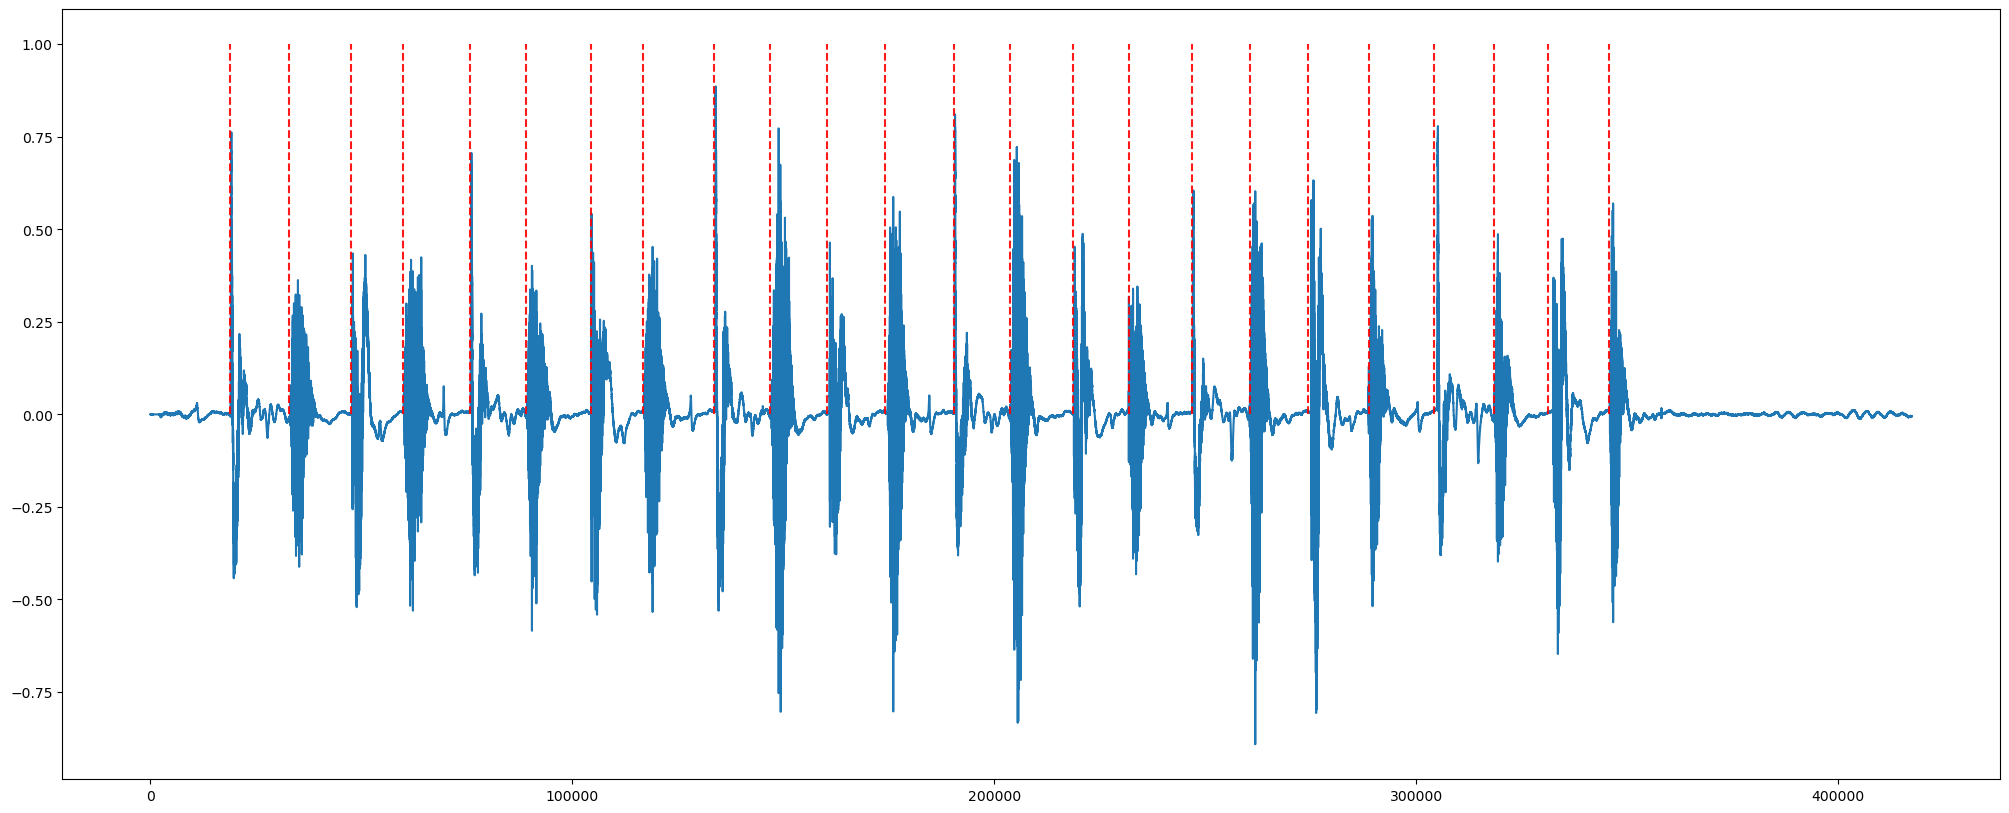

In [35]:
# load 477 beatboxing file for testing
beatbox_test, beatbox_sr = librosa.load("beatboxtest.wav", sr = None)

test_onsets = librosa.onset.onset_detect(y = beatbox_test, sr = beatbox_sr, units = 'samples', backtrack = True, normalize = True, delta = .2)

plt.figure(figsize = (25,10))
plt.plot(beatbox_test)
plt.vlines(test_onsets, ymin = 0, ymax = 1,color='r', alpha=0.9,
           linestyle='--', label='Onsets')

print('test onsets: ', test_onsets)

In [44]:
# slice audio into individual drum sounds

slices = []
test_mel_specs = []

for i, onset in enumerate(test_onsets):
    slices.append(beatbox_test[onset : onset+11025])
    test_mel_specs.append(get_mel_spectrogram(slices[i]))
